# notMINST Data Exploration using Tensorflow 2.0.0

This notebook uses the notMNIST dataset. This dataset is designed to look like the classic MNIST dataset, while looking a little more like real data. The data is a lot less 'clean' than MNIST.

The notMNIST dataset is a image recognition dataset of font glypyhs for the letters A through J useful with simple neural networks. It is quite similar to the classic MNIST dataset of handwritten digits 0 through 9. the NotMNIST dataset comprises 28x28 grayscale images.

## Workflow

*   Download / load raw notMNIST dataset
*   Drop unreadable images and save the remaining images
*   Combine all images and divide it into testing/validation/test set
*   Shuffle / Randomize the dataset
*   Build DEEP ANN model using Tensorflow 2.0.0 for image recognition using different size of training data


## Importing required libraries

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 86kB/s 
     |████████████████████████████████| 450kB 47.3MB/s 
     |████████████████████████████████| 3.8MB 47.1MB/s 
ERROR: tensorflow 1.15.0rc3 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0rc3 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [0]:
import os, sys
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

#from scipy import ndimage
#from IPython.display import display, Image
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

In [3]:
print(tf.version.VERSION)
print('GPU is', 'available' if tf.config.experimental.list_physical_devices('GPU') else 'NOT AVAILABLE')

2.0.0
GPU is available


In [4]:
random.seed(321)
np.random.seed(321)
tf.random.set_seed(321)

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

plt.figure(figsize = (14, 11))
plt.style.use('seaborn')

colors = mcolors.TABLEAU_COLORS

sns.set(rc = {'figure.figsize':(14, 11), 'figure.facecolor':'whitesmoke', 'axes.facecolor':'whitesmoke', 'grid.color':'slategrey'})
sns.color_palette(list(colors.values()));

<Figure size 1008x792 with 0 Axes>

## Download and extract the dataset into folders by characters

Download compressed dataset. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples.

In [0]:
from tqdm import tqdm
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num


def downloadDataset(url, filename, folderpath = '') :
    from urllib.request import urlretrieve
    from os.path import isfile, isdir
    import tarfile

    if not isfile(filename):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc=filename + ' Dataset') as pbar:
            urlretrieve(url, filename, pbar.hook)
    
    if not isdir(folderpath):
        with tarfile.open(filename) as tar:
            tar.extractall()
            tar.close()

In [6]:
downloadDataset('http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz', 'notMNIST_large.tar.gz')

notMNIST_large.tar.gz Dataset: 247MB [00:10, 24.1MB/s]                           


In [7]:
downloadDataset('http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz', 'notMNIST_small.tar.gz')

notMNIST_small.tar.gz Dataset: 8.46MB [00:01, 6.71MB/s]                           


## Display some images in dataset and render them

Let's take a peek at some of the data to make sure it looks sensible.

notMNIST_large/A/QWNoZSBDb25kZW5zZWQgTm9ybWFsLnR0Zg==.png


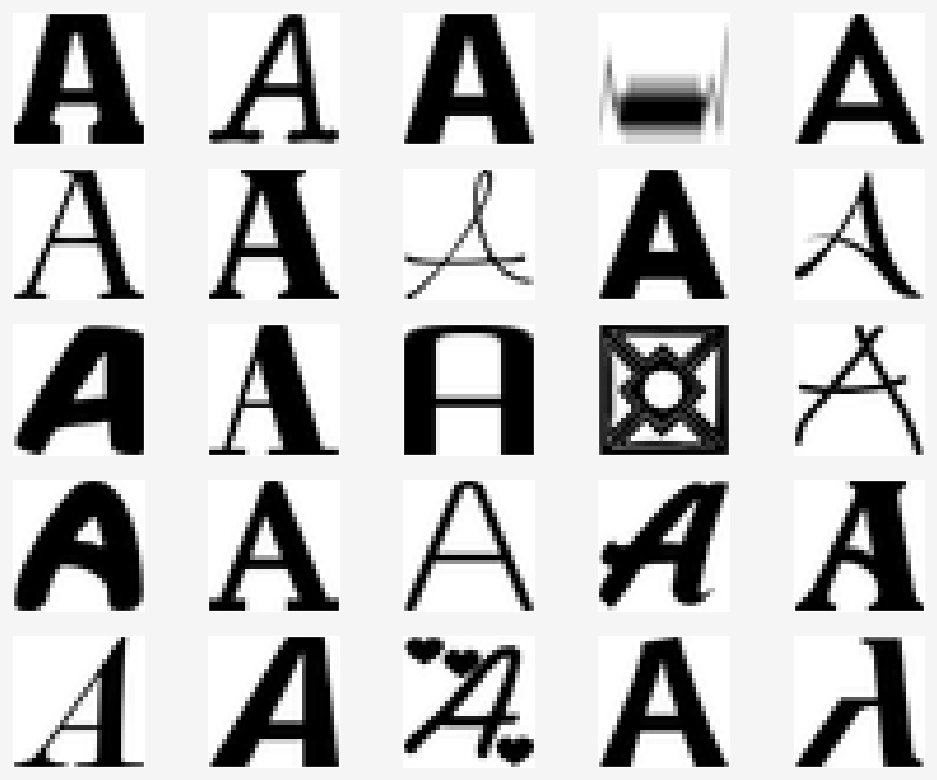

In [8]:
# Display first 25 images from A class
path = 'notMNIST_large/A'
filenames = os.listdir(path)

print (path + os.sep + filenames[0])

for i in range(25):
    img = Image.open(path + os.sep + filenames[i])
    arr = np.array(img)

    plt.subplot(5, 5, i+1)
    plt.imshow(arr, cmap=plt.cm.gray_r)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show();

notMNIST_large/B/QWNoZSBDb25kZW5zZWQgTm9ybWFsLnR0Zg==.png


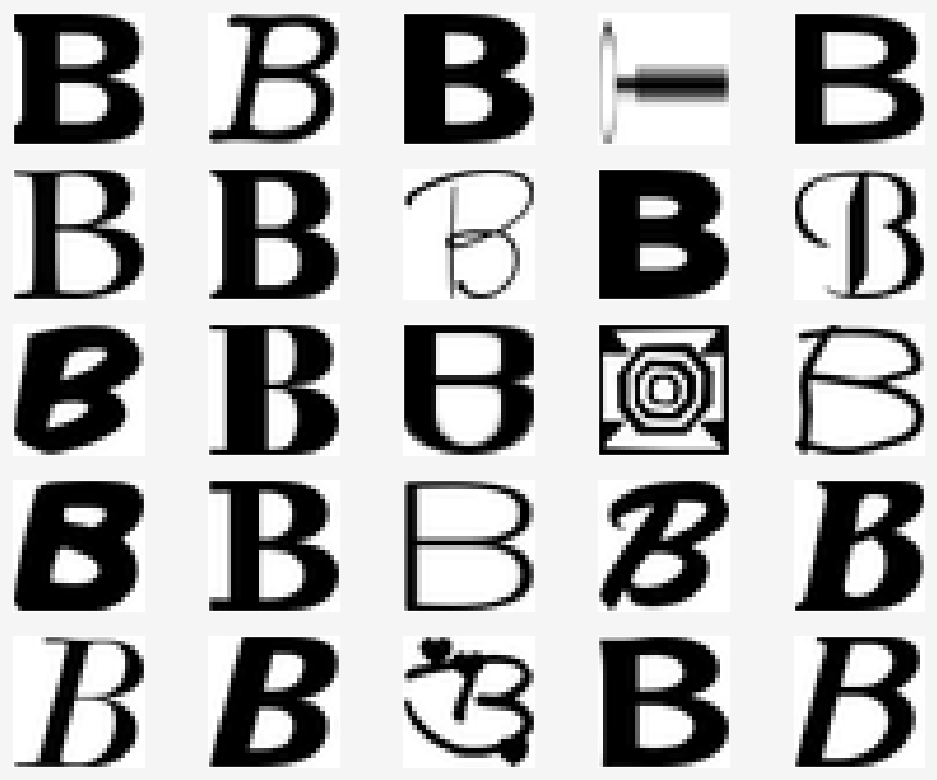

In [9]:
# Display first 25 images from B class
path = 'notMNIST_large/B'
filenames = os.listdir(path)

print (path + os.sep + filenames[0])

for i in range(25):
    img = Image.open(path + os.sep + filenames[i])
    arr = np.array(img)

    plt.subplot(5, 5, i+1)
    plt.imshow(arr, cmap=plt.cm.gray_r)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show();

## Data curation

*   Normalization

Now let's load the data in a more manageable format. Convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.

In [0]:
classList = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
classDict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9}
classLabels = {k : v for (k, v) in zip(np.arange(10), 'ABCDEFGHIJ')}

image_size = 28

In [11]:
path = 'notMNIST_small/'

total_good_images = 0
for root, dirs, files in os.walk(path, topdown=True) :
    for imgfile in files:
        try:
            img = Image.open(os.path.join(root, imgfile))
            total_good_images = total_good_images + 1
            img.close()
        except:
            print('Bad file: ' + os.path.join(root, imgfile))

test_features = np.ndarray(shape=(total_good_images, image_size, image_size), dtype=np.float32)
test_target = np.ndarray(shape=(total_good_images, 1), dtype=np.int32)
num_images = 0

for root, dirs, files in os.walk(path, topdown=True) :
    for imgfile in files:
        try:
            img = Image.open(os.path.join(root, imgfile))
            img2arr = np.array(img, dtype=np.float32)
            img2arr = img2arr / 255.0
            test_features[num_images, :, :] = img2arr
            test_target[num_images, :] = classDict.get(os.path.basename(root))
            num_images = num_images + 1
            img.close()
        except:
            print('Bad file: ' + os.path.join(root, imgfile))

Bad file: notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png
Bad file: notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
Bad file: notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png
Bad file: notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png


In [12]:
path = 'notMNIST_large/'

total_good_images = 0
for root, dirs, files in os.walk(path, topdown=True) :
    for imgfile in files:
        try:
            img = Image.open(os.path.join(root, imgfile))
            total_good_images = total_good_images + 1
            img.close()
        except:
            print('Bad file: ' + os.path.join(root, imgfile))

train_features = np.ndarray(shape=(total_good_images, image_size, image_size), dtype=np.float32)
train_target = np.ndarray(shape=(total_good_images, 1), dtype=np.int32)
num_images = 0

for root, dirs, files in os.walk(path, topdown=True) :
    for imgfile in files:
        try:
            img = Image.open(os.path.join(root, imgfile))
            img2arr = np.array(img, dtype=np.float32)
            img2arr = img2arr / 255.0
            train_features[num_images, :, :] = img2arr
            train_target[num_images, :] = classDict.get(os.path.basename(root))
            num_images = num_images + 1
            img.close()
        except:
            print('Bad file: ' + os.path.join(root, imgfile))

Bad file: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png
Bad file: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png
Bad file: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png
Bad file: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png
Bad file: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png
Bad file: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png
Bad file: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png
Bad file: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png
Bad file: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png
Bad file: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png


## Verify Data

Displaying a sample of the labels and images from the ndarray.

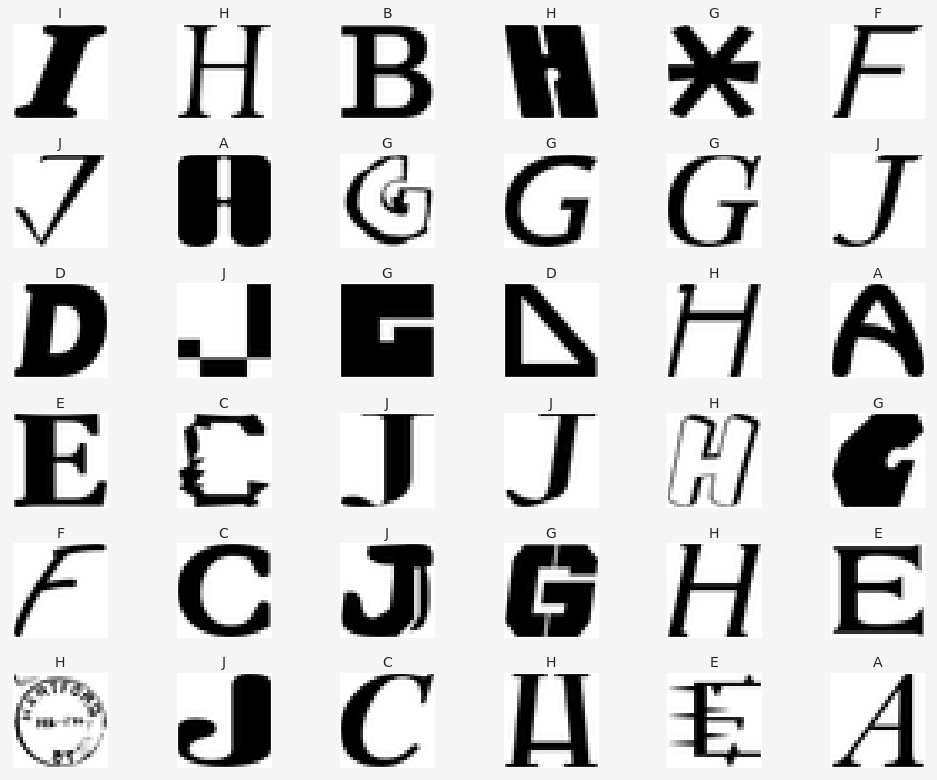

In [13]:
for i in range(36):
    imgno = random.randint(0,len(train_target))
    plt.subplot(6, 6, i+1)
    plt.imshow(train_features[imgno], cmap=plt.cm.gray_r)
    plt.title(classLabels[train_target[imgno][0]], fontsize = 14)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show();

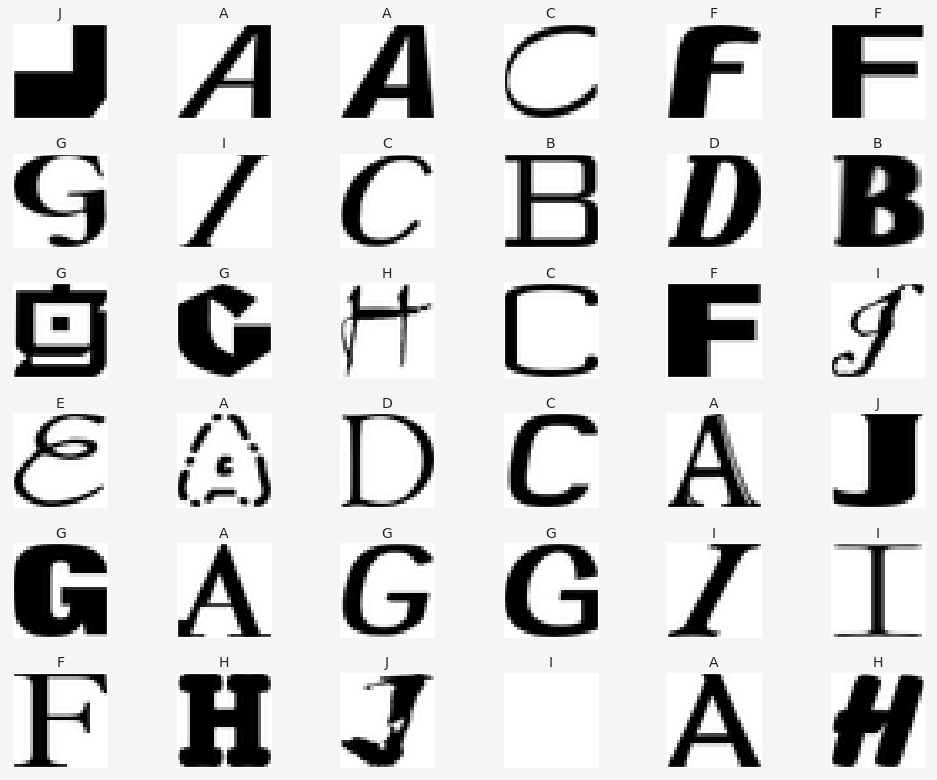

In [14]:
for i in range(36):
    imgno = random.randint(0,len(test_target))
    plt.subplot(6, 6, i+1)
    plt.imshow(test_features[imgno], cmap=plt.cm.gray_r)
    plt.title(classLabels[test_target[imgno][0]], fontsize = 14)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show();

## Is data balanced across classes

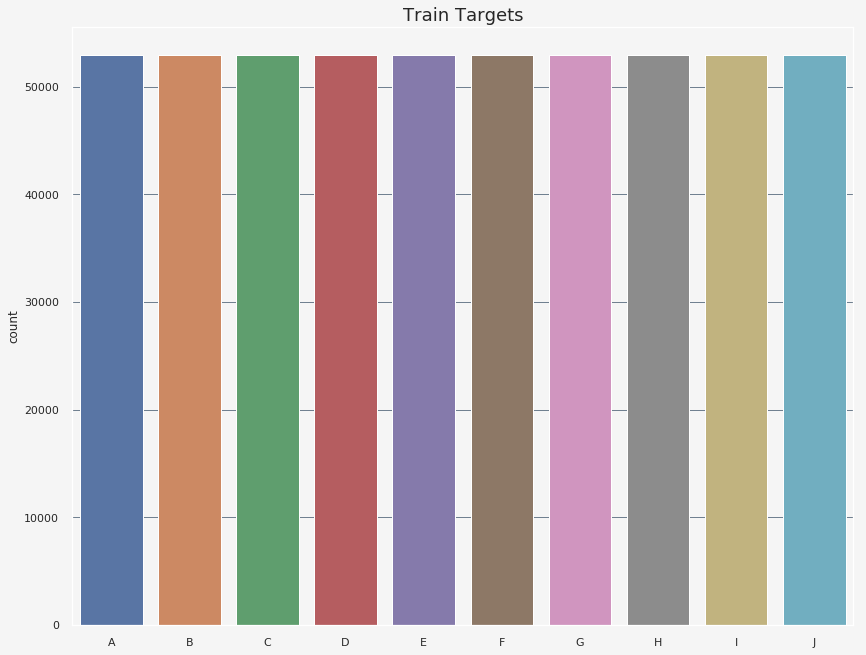

In [15]:
sns.countplot(x=train_target[:, -1])
plt.xticks(np.arange(10), ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'))
plt.title('Train Targets', fontsize=18)
plt.show()

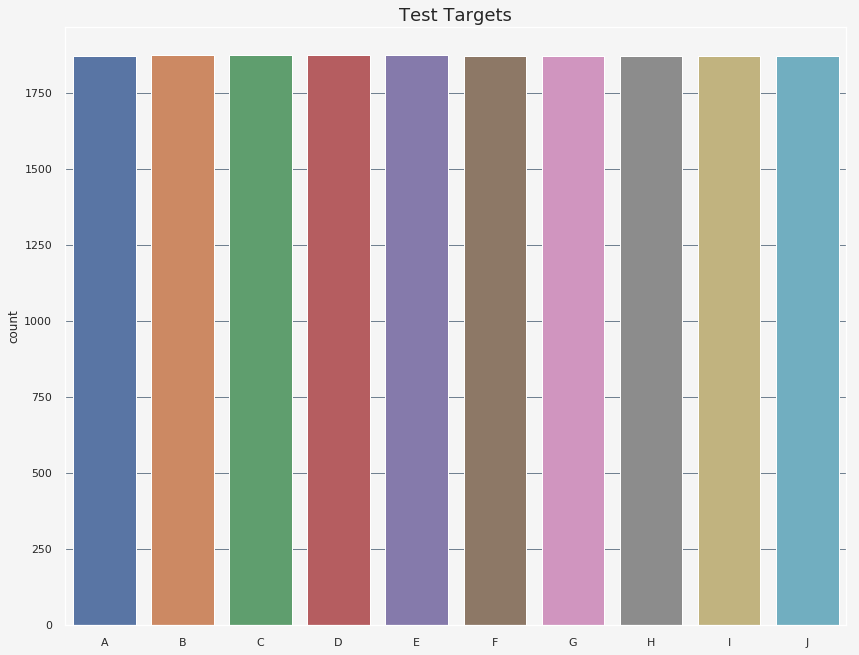

In [16]:
sns.countplot(x=test_target[:, -1])
plt.xticks(np.arange(10), ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'))
plt.title('Test Targets', fontsize=18)
plt.show()

## Randomize the data

The purpose of randomizing data is to perserve the assumption that we get the data randomly as predict phase. We don't want to train models sequantially on training instances like AAA ... BBB ... CCC.

In [0]:
idx = np.random.permutation(len(train_target))

X, y = train_features[idx], train_target[idx]

## Splitting the data into Training and Validation sets

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((396835, 28, 28), (132279, 28, 28), (396835, 1), (132279, 1))

## Training Artificial Neural Network (ANN) using Tensorflow 2.0.0

In [19]:
# Set the input and output sizes
input_size = 784
output_size = 10

# Useing same hidden layer size for all hidden layers.
hidden_layer_size = 512

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='softmax'),
    ])

# Choose the optimizer, the loss function and the metrics
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Set the batch size
batch_size = 250000

# Set a maximum number of training epochs
max_epochs = 100

# Set an early stopping mechanism
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

# Fit the model
history = model.fit(
    X_train,
    y_train,
    #batch_size=batch_size,
    epochs=max_epochs,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    verbose=2,
    )

Train on 396835 samples, validate on 132279 samples
Epoch 1/100
396835/396835 - 75s - loss: 0.5126 - sparse_categorical_accuracy: 0.8483 - val_loss: 0.4022 - val_sparse_categorical_accuracy: 0.8795
Epoch 2/100
396835/396835 - 74s - loss: 0.4241 - sparse_categorical_accuracy: 0.8738 - val_loss: 0.3663 - val_sparse_categorical_accuracy: 0.8901
Epoch 3/100
396835/396835 - 73s - loss: 0.3983 - sparse_categorical_accuracy: 0.8817 - val_loss: 0.3475 - val_sparse_categorical_accuracy: 0.8962
Epoch 4/100
396835/396835 - 74s - loss: 0.3785 - sparse_categorical_accuracy: 0.8875 - val_loss: 0.3400 - val_sparse_categorical_accuracy: 0.8993
Epoch 5/100
396835/396835 - 74s - loss: 0.3689 - sparse_categorical_accuracy: 0.8905 - val_loss: 0.3364 - val_sparse_categorical_accuracy: 0.9000
Epoch 6/100
396835/396835 - 75s - loss: 0.3603 - sparse_categorical_accuracy: 0.8933 - val_loss: 0.3328 - val_sparse_categorical_accuracy: 0.9021
Epoch 7/100
396835/396835 - 74s - loss: 0.3558 - sparse_categorical_accu

## Plotting model performance on accuracy and loss

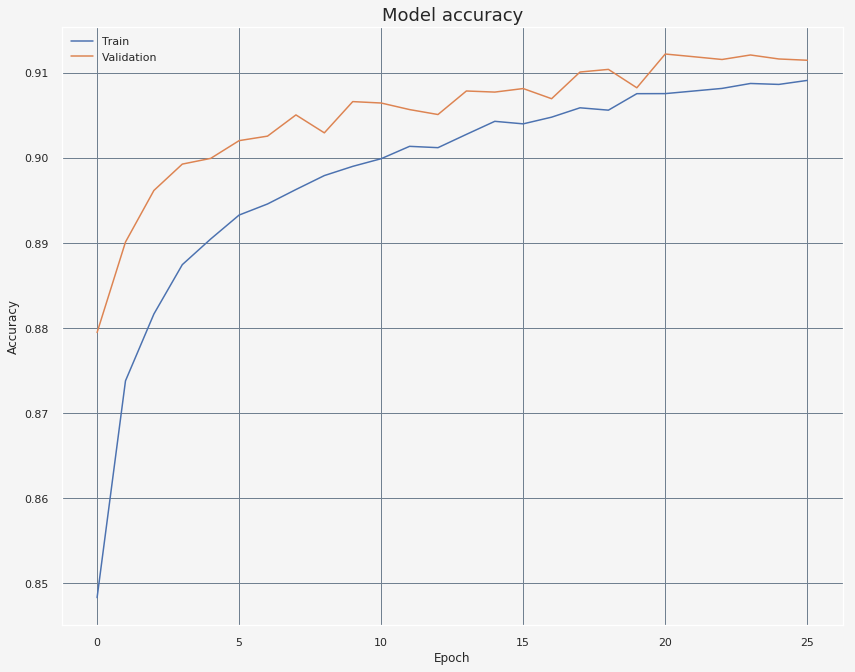

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy', fontsize=18)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

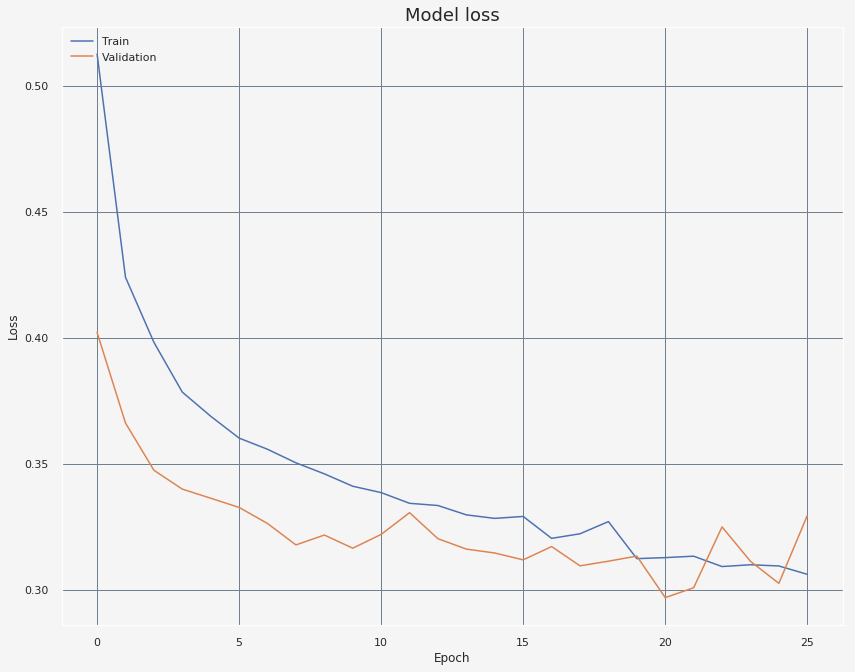

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss', fontsize=18)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

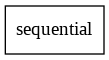

In [22]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)

## Calculating the Accuracy on the Test Data

In [23]:
test_loss, test_accuracy = model.evaluate(test_features, test_target, verbose = 0)

print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy * 100.0))


Test loss: 0.15. Test accuracy: 96.21%


## Predicting on Test Data

In [0]:
predictions = model.predict_classes(test_features)

In [25]:
predictions.shape, test_target.shape

((18724,), (18724, 1))

In [26]:
predictions

array([3, 3, 3, ..., 0, 0, 0])

In [27]:
print(classification_report(test_target[:, -1], predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1872
           1       0.96      0.96      0.96      1873
           2       0.99      0.95      0.97      1873
           3       0.97      0.97      0.97      1873
           4       0.95      0.97      0.96      1873
           5       0.99      0.96      0.98      1872
           6       0.93      0.96      0.95      1872
           7       0.97      0.97      0.97      1872
           8       0.93      0.94      0.93      1872
           9       0.97      0.97      0.97      1872

    accuracy                           0.96     18724
   macro avg       0.96      0.96      0.96     18724
weighted avg       0.96      0.96      0.96     18724



In [28]:
print(confusion_matrix(test_target[:, -1], predictions))

[[1820    7    0    4    0    0    9   16   16    0]
 [   8 1800    1   11   16    0   15   10   10    2]
 [   2    2 1779    3   27    1   46    2   11    0]
 [   4   17    1 1819    2    0    6    5   10    9]
 [   3    7    7    5 1811    6   20    3    9    2]
 [   7    4    0    3   18 1800   11    4   18    7]
 [   8   14   13    3   12    3 1794    4   16    5]
 [  13   10    2    4    1    3    4 1818   16    1]
 [  16   14    2   14   17    0   10    5 1757   37]
 [   5    3    0   12    3    0    4    1   27 1817]]


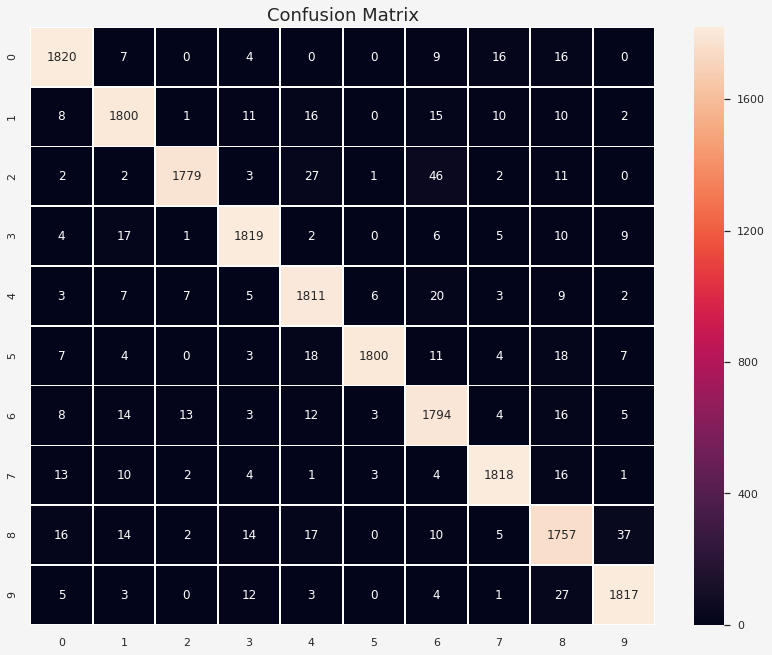

In [29]:
sns.heatmap(confusion_matrix(test_target[:, -1], predictions), annot=True, fmt="d", linewidths=0.75)
plt.title('Confusion Matrix', fontsize = 18)
plt.show()